In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 
%matplotlib inline

from skimage import (io,exposure,feature,segmentation, morphology,filters,measure,
                     color,restoration, img_as_ubyte,img_as_uint,img_as_float)


from scipy import ndimage as ndi

plt.rcParams['image.cmap']='gray'

In [2]:
def plot_print(*img):
    """
    print 2 or 3 plot side by side
    """
    if len(img) == 2:
        plt.figure(figsize=(20,10))
        plt.subplot(121)
        plt.imshow(img[0])
        plt.subplot(122)
        plt.imshow(img[1])
    else:
        plt.figure(figsize=(30,15))
        plt.subplot(131)
        plt.imshow(img[0])
        plt.subplot(132)
        plt.imshow(img[1])
        plt.subplot(133)
        plt.imshow(img[2])

In [3]:
def denoising(image, connect=2, percentage=10):
    """
    removing labels that their areas are less than determined percentage of total area of labels
    
    params- image : binary image
            connectivity to seprate region
            percentage
            
    return tabel of labels
    """
    
    labeled_img = measure.label(image,connectivity = connect)
    table = measure.regionprops_table(labeled_img, properties=['area','label'])
    df = pd.DataFrame(table)
    df = df.set_index('label')  
    df_sorted = df.sort_values(by='area')
    df_sorted_C = df_sorted.cumsum()
    selected_labels = df_sorted_C[df_sorted_C['area']>(df['area'].sum()/percentage)]
    
    denoised_img = np.zeros(labeled_img.shape,dtype = 'uint8')

    for i in range(labeled_img.shape[0]):
        for j in range(labeled_img.shape[1]):
            if labeled_img[i,j] in selected_labels.index:
                denoised_img[i,j] = 1
    
    
    
    return selected_labels, denoised_img
     

def edgedot(image,skeleton,l,min_l=0):
    """
    detect the branch points and collect them, afterward a window with given size centered at the branch point 
    and grab the intersection of each centerline with the edge of the window, if the number of point is other than 3 that 
    means the window had been too large so the size of the window start minimizing until the number of points become equal
    to 3, while considering a minimum size of window to avoid cutting very small branches. Also if the branch point happen
    to place near the border the window will be adjusted to the minmun distance of branch point from the border.   
    
    param    image : image to be seprating its cracks 
             skeleton : a skeletonized image
             l : size of window
             min_l : the minmum size of window to avoid cut small crack branch 
    
    return   img : seprated image
             branch_point : the coordinates of all of branch points in a list as a tuple
             win : window on each branch point with dots on edges
             win_dot : a dictionary with coordinates of each edge dot in window
             mask : seprating mask in each window
    """
    K = l
    img = image.copy()
    skelet = skeleton.copy()
    skelet_1 = skeleton.copy()
#Branch point detection and removing 

    branch_point = []

    for i in range (1,skelet.shape[0]-1):
        for j in range(1,skelet.shape[1]-1):
            if skelet[i,j]==1 and cv2.countNonZero(skelet[i-1:i+2,j-1:j+2])>3:
                skelet[i-1:i+2,j-1:j+2]=0
                branch_point.append((i,j))

    
# creating window and placing the window on each branch point    
    
    win=[]
    win_dot={}
    count = 0
    
    for d in range(len(branch_point)):
        l = K
        # for those branch points which are close to the border and the window can not properly place on them so
        # the size of the window will be adjusted to the minmun distance of branch point from the border 
        if (branch_point[d][0] < l) | (branch_point[d][1] < l) | (image.shape[0]-1-branch_point[d][0] < l) | (image.shape[1]-1- branch_point[d][1]< l):
          
            l = min([branch_point[d][0], branch_point[d][1], image.shape[0]-1-branch_point[d][0], image.shape[1]-1-branch_point[d][1]])
        
        
        
        while True:
            win.append(np.zeros((2*l+1,2*l+1),dtype="uint8"))
            win_dot[d]=[]
            win_dot[d].append((l,l))
            for i in range(win[d].shape[0]):

                if skelet_1[branch_point[d][0]-l:branch_point[d][0]+l+1,branch_point[d][1]-l:branch_point[d][1]+l+1][i,0] == 1:
                    win[d][i,0]=1
                    win_dot[d].append((i,0))

                if skelet_1[branch_point[d][0]-l:branch_point[d][0]+l+1,branch_point[d][1]-l:branch_point[d][1]+l+1][i,win[d].shape[0]-1] == 1:
                    win[d][i,win[d].shape[0]-1]=1
                    win_dot[d].append((i,win[d].shape[0]-1))

            for j in range(1,win[d].shape[0]-1):   

                if skelet_1[branch_point[d][0]-l:branch_point[d][0]+l+1,branch_point[d][1]-l:branch_point[d][1]+l+1][0,j] == 1:
                    win[d][0,j]=1
                    win_dot[d].append((0,j))

                if skelet_1[branch_point[d][0]-l:branch_point[d][0]+l+1,branch_point[d][1]-l:branch_point[d][1]+l+1][win[d].shape[0]-1,j] == 1:
                    win[d][win[d].shape[0]-1,j]=1
                    win_dot[d].append((win[d].shape[0]-1,j))


                win[d][l,l]=1
            
            if (len(win_dot[d])==4) | ((l == min_l) & (len(win_dot[d])<=4)) :
                break
            else:
                l = l - 1
                
                del win[d]

            

     
    #drawing sepration line on mask
    mask = []
    
    for d in range(len(branch_point)):
        mask.append(np.zeros(win[d].shape,dtype="uint8"))

        try:
            cv2.line(mask[d], win_dot[d][0],
                              ((round((win_dot[d][1][1]+win_dot[d][3][1])/2)-win_dot[d][0][0])*2*l+round((win_dot[d][1][1]+win_dot[d][3][1])/2),
                               (round((win_dot[d][1][0]+win_dot[d][3][0])/2)-win_dot[d][0][1])*2*l+round((win_dot[d][1][0]+win_dot[d][3][0])/2)),1)

            cv2.line(mask[d], win_dot[d][0],
                              ((round((win_dot[d][2][1]+win_dot[d][3][1])/2)-win_dot[d][0][0])*2*l+round((win_dot[d][2][1]+win_dot[d][3][1])/2),
                               (round((win_dot[d][2][0]+win_dot[d][3][0])/2)-win_dot[d][0][1])*2*l+round((win_dot[d][2][0]+win_dot[d][3][0])/2)),1)

            cv2.line(mask[d], win_dot[d][0],
                              ((round((win_dot[d][1][1]+win_dot[d][2][1])/2)-win_dot[d][0][0])*2*l+round((win_dot[d][1][1]+win_dot[d][2][1])/2),
                               (round((win_dot[d][1][0]+win_dot[d][2][0])/2)-win_dot[d][0][1])*2*l+round((win_dot[d][1][0]+win_dot[d][2][0])/2)),1)
        except:
            continue        
    
    #masking the cuting line from the original image
    for d in range(len(branch_point)):

        img[branch_point[d][0]-mask[d].shape[0]//2:branch_point[d][0]+mask[d].shape[0]//2+1,branch_point[d][1]-mask[d].shape[0]//2:branch_point[d][1]+mask[d].shape[0]//2+1] = img[branch_point[d][0]-mask[d].shape[0]//2:branch_point[d][0]+mask[d].shape[0]//2+1,branch_point[d][1]-mask[d].shape[0]//2:branch_point[d][1]+mask[d].shape[0]//2+1] - mask[d]

        for i in range(branch_point[d][0]-mask[d].shape[0]//2,branch_point[d][0]+mask[d].shape[0]//2+1):
            for j in range(branch_point[d][1]-mask[d].shape[0]//2,branch_point[d][1]+mask[d].shape[0]//2+1):
                if img[i,j] == 255 :
                    img[i,j] = 0 
    
    
    
    return img, branch_point, win, win_dot, mask


def crack_labeling(image,connect=1):
    """labeling the seperated image and show in different color and seprately in window
    
    param    image: seprated image
             connect: connectivity of seprating cracks region
             
    show   image with different color of every region
             and seprately each ceprated region
    """
    labeled_cracks = measure.label(image,connectivity=connect)

    new_table = measure.regionprops_table(labeled_cracks,properties=['slice','area','label'])
    
    

    plt.figure(figsize=(10,20))
    
    for n, single_w in enumerate(new_table['slice']):
        ax = plt.subplot(len(new_table['slice']), 1, n+1)

        plt.imshow(labeled_cracks[single_w]==(n+1))
        
    plt.tight_layout()
    plt.show()   
    return plt.imshow(labeled_cracks,cmap="CMRmap")

def remove_non_crack(img,f=0.1):
    """
    calculation the area of each crack(region) and deviding into the area of the circumscribed circle and remove
    those region that has retio more than threshold
    
    param    img : image to be remove noncracks
             f : the threshold which its defult is 0.1   
    
    return:  slices of cracks
    """

    labeled_cracks = measure.label(img,connectivity=1)

    new_table = measure.regionprops_table(labeled_cracks,properties=['slice','area','label'])
    ntdf = pd.DataFrame(new_table)
    ntdf['Ac'] = ntdf['slice'].apply(lambda x : np.pi*max(labeled_cracks[x].shape))**2//4
    ntdf['Fpd'] = ntdf['area']/ntdf['Ac']
    ntdf['tuple'] = ntdf.apply(lambda x : (x['label'],x['slice']),axis=1)
    only_cracks = pd.DataFrame(ntdf[ntdf['Fpd'] < f]['tuple']).reset_index().drop('index',axis=1)
    
    plt.figure(figsize=(40,40))

    for n, single_w in enumerate(only_cracks['tuple']):

        ax = plt.subplot(len(only_cracks['tuple']), 1, n+1)

        plt.imshow(labeled_cracks[single_w[1]]==single_w[0])
    plt.tight_layout()
    plt.show()  
    
    return only_cracks['tuple']
    

def crack_quantification(img,connect=1,f=0.1):
    """
    First calculate the area of each crack (region) and deviding into the area of the circumscribed circle and remove
    those region that has retio more than threshold afterward calculate the angle and width of each crack 
    
    param    img : seprated cracks image 
             connect : connectivity of labeling
             f : the threshold which its defult is 0.1
             
    return:  crack_quantification : a pandas dataframe of average width and angle
                                    and slice of each crack
             cracks_width : The width of crack in each centerline pixel
             cracks_angle : The angle of crack in each centerline pixel
             
    
    
    """

    labeled_cracks = measure.label(img,connectivity=connect)

    new_table = measure.regionprops_table(labeled_cracks,properties=['slice','area','label'])
    ntdf = pd.DataFrame(new_table)
    ntdf['Ac'] = ntdf['slice'].apply(lambda x : np.pi*max(labeled_cracks[x].shape))**2//4
    ntdf['Fpd'] = ntdf['area']/ntdf['Ac']
    ntdf['tuple'] = ntdf.apply(lambda x : (x['label'],x['slice']),axis=1)
    only_cracks = pd.DataFrame(ntdf[ntdf['Fpd'] < f]['tuple']).reset_index().drop('index',axis=1)    
        


#crack quantification

    
    cracks= {}
    for n , item in enumerate(only_cracks['tuple']):
        cracks[n] = img_as_float(labeled_cracks[item[1]]==item[0])

    cracks_ske={}
    for item in cracks:
        cracks_ske[item] = img_as_float(skeletonize(cracks[item],method='lee'))    

    #filters of detecting crack's angle    
    fil_0 = np.zeros((21,21))
    fil_0[8:13,:]=1
    fil_30 = np.zeros((21,21))
    cv2.line(fil_30, (0,15),(20,5),1,5)
    fil_60 = np.zeros((21,21))
    cv2.line(fil_60, (15,0),(5,20),1,5)
    fil_90 = np.zeros((21,21))
    fil_90[:,8:13]=1
    fil_120 = np.zeros((21,21))
    cv2.line(fil_120, (0,5),(20,15),1,5)
    fil_150 = np.zeros((21,21))
    cv2.line(fil_150, (5,0),(15,20),1,5)



    filt= {'0':fil_0,'30':fil_30,'60':fil_60,'90':fil_90,'120':fil_120,'150':fil_150}

    


    cracks_filt={}

    for i in cracks:
        step={}
        cracks_filt[i] = step
        for item in filt:
            step[item] =  ndi.convolve(cracks[i],filt[item],mode='constant')

    cracks_merge={}

    for i in cracks_filt:
        cracks_merge[i] = cv2.merge([cracks_filt[i]['0'],
                                     cracks_filt[i]['30'],
                                     cracks_filt[i]['60'],
                                     cracks_filt[i]['90'],
                                     cracks_filt[i]['120'],
                                     cracks_filt[i]['150']])


    cracks_centerlines = {}

    for item in cracks_ske:
        cracks_centerlines[item]=[]
        for i in range(cracks_ske[item].shape[0]):
            for j in range(cracks_ske[item].shape[1]):
                if cracks_ske[item][i,j] == 1:
                    cracks_centerlines[item].append(cracks_merge[item][i,j])



    cracks_width = {}
    for i in cracks_centerlines:
        cracks_width[i]=[]
        for item in cracks_centerlines[i]:
            cracks_width[i].append(item.min()/5)

    cracks_width_mean = {}
    for item in cracks_width:
        cracks_width_mean[item]= sum(cracks_width[item])/len(cracks_width[item])

    cracks_angle = {}
    for i in cracks_centerlines:
        cracks_angle[i]=[]
        for item in cracks_centerlines[i]:
            for n, angle in enumerate(item):
                if angle == item.min():
                    cracks_angle[i].append(n)

    dic = {0:90,1:120,2:150,3:0,4:30,5:60}

    for item in cracks_angle:
        cracks_angle[item] = list(map(dic.get, cracks_angle[item]))

    cracks_angle_mean = {}
    for item in cracks_angle:
        cracks_angle_mean[item]= sum(cracks_angle[item])/len(cracks_angle[item])

    crack_quantification = {}

    crack_quantification['cracks_slice'] = only_cracks['tuple']
    crack_quantification['cracks_width_mean'] = cracks_width_mean
    crack_quantification['cracks_angle_mean'] = cracks_angle_mean

    crack_quantification = pd.DataFrame(crack_quantification)

    # show selected cracks
    plt.figure(figsize=(10,30))

    for n, single_w in enumerate(only_cracks['tuple']):

        ax = plt.subplot(len(only_cracks['tuple']), 1, n+1)

        plt.imshow(labeled_cracks[single_w[1]]==single_w[0])
    plt.tight_layout()
    plt.show()
    
    return crack_quantification, cracks_width, cracks_angle 

In [4]:
img= io.imread('crack.jpg')
img = img[5:,:]

# Equalization 

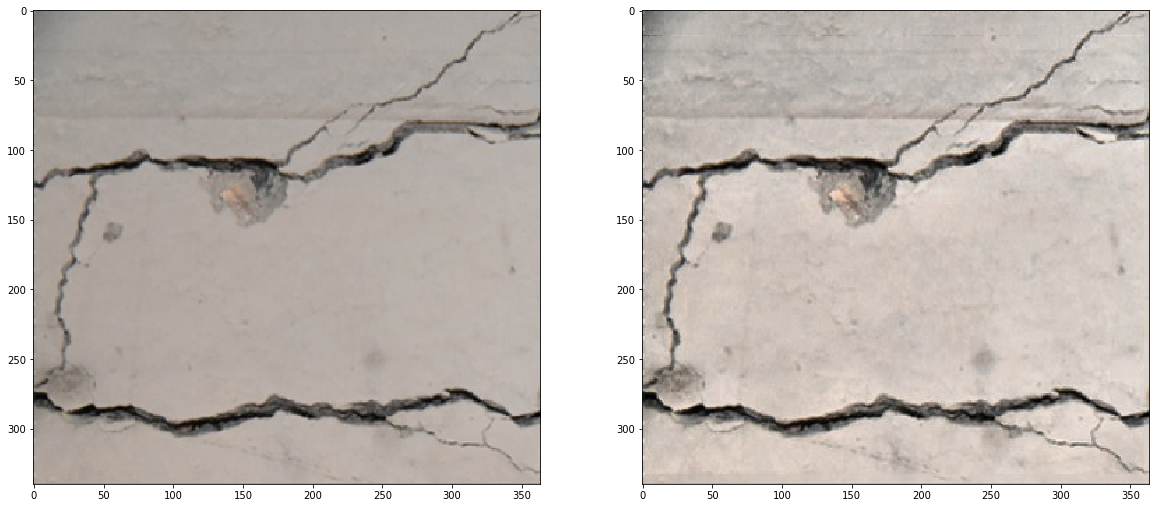

In [5]:
equ=exposure.equalize_adapthist(img)

plot_print(img,equ)

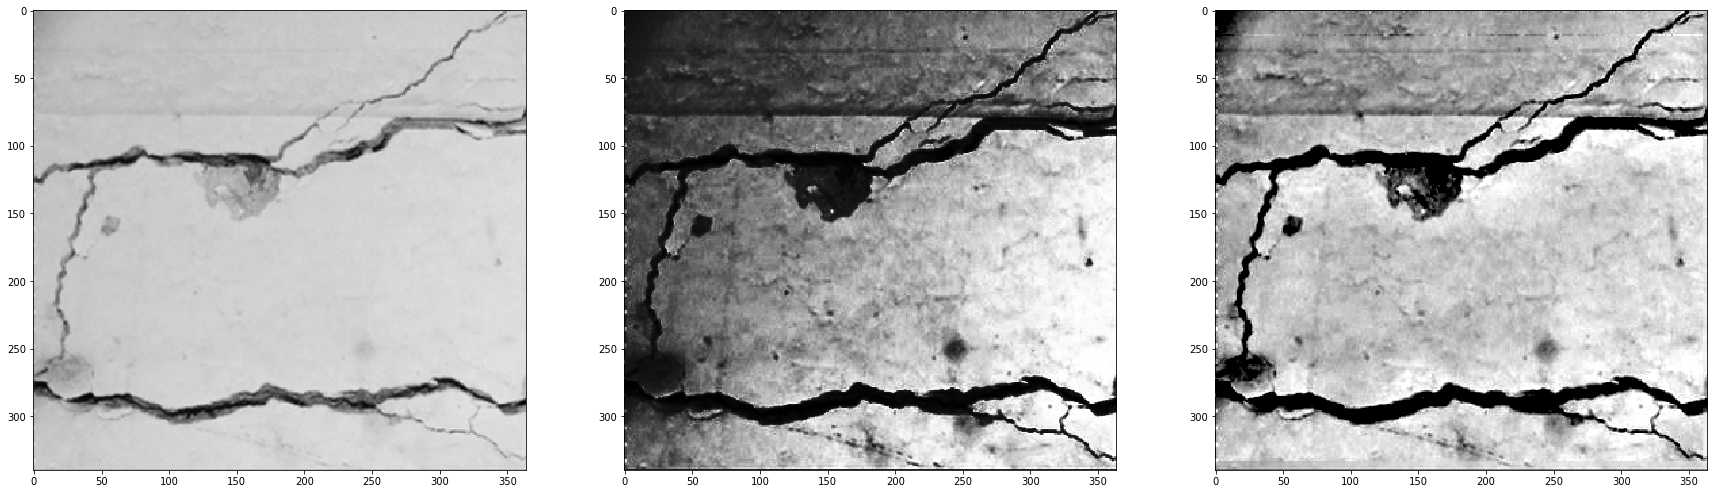

In [6]:
from skimage.color import rgb2gray

gray = rgb2gray(img)
gray_equ = rgb2gray(equ)

img_eq = exposure.equalize_hist(gray)

#Contrast stretching 
p2, p98 = np.percentile(gray_equ, (7, 98))
img_rescale = exposure.rescale_intensity(gray_equ, in_range=(p2, p98))

plot_print(gray,img_eq,img_rescale)

# Binarization 

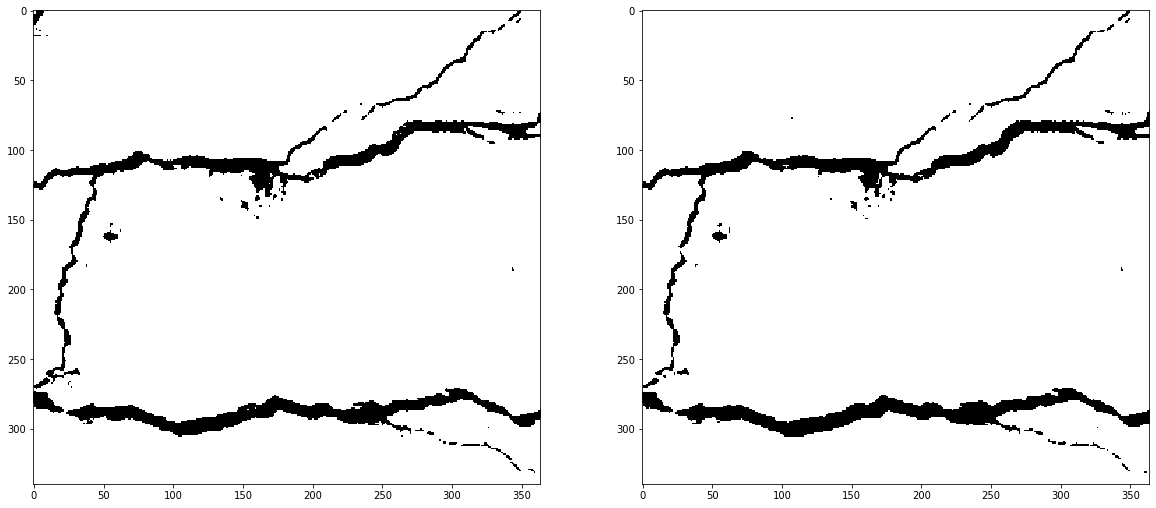

In [7]:
from skimage.filters import threshold_multiotsu, threshold_otsu,threshold_sauvola

thresh_sauvola = threshold_sauvola(img_as_ubyte(gray), 51)
binary_sauvola = img_as_ubyte(gray) > thresh_sauvola
thresh_sauvola_equ = threshold_sauvola(img_as_ubyte(gray_equ), 51)
binary_sauvola_equ = img_as_ubyte(gray_equ) > thresh_sauvola
plot_print(binary_sauvola_equ,binary_sauvola)

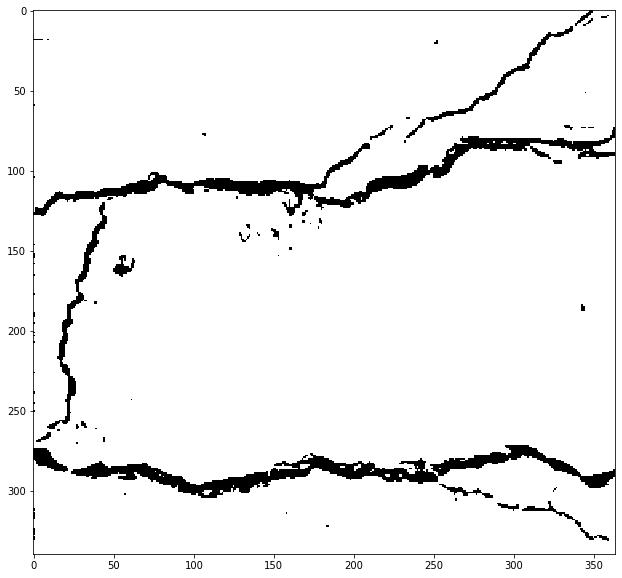

In [8]:
thr2=filters.threshold_local(img_as_ubyte(gray_equ),51,offset=40)
binary_local = img_as_ubyte(gray_equ)>thr2
plt.figure(figsize=(20,10))
plt.imshow(binary_local)


# Morphological Filtering

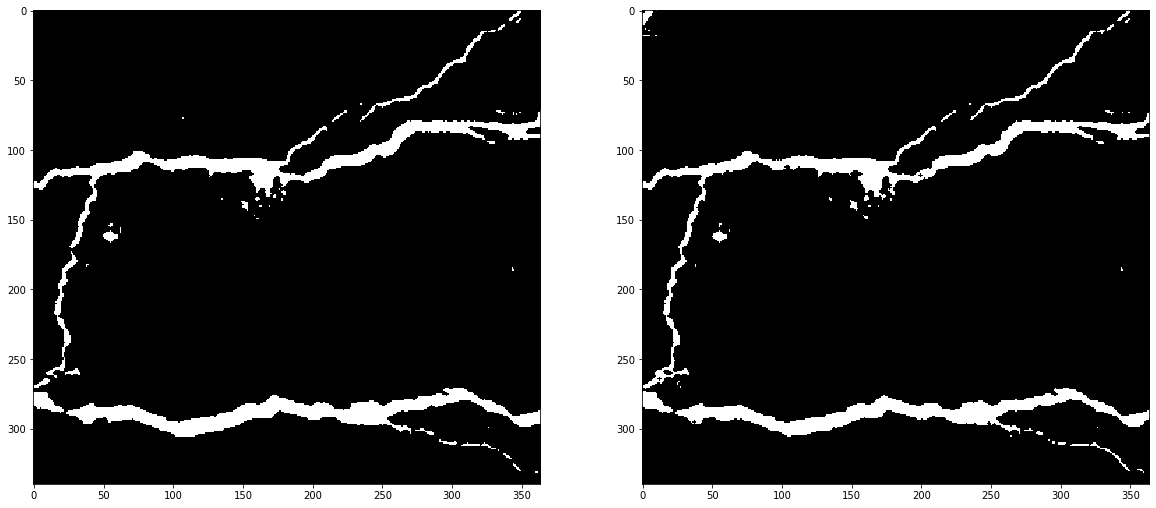

In [9]:
from skimage.morphology import erosion, dilation, opening, closing, white_tophat
from skimage.morphology import black_tophat, skeletonize, convex_hull_image, disk

binary_sauvola_equ = ~ binary_sauvola_equ
binary_sauvola = ~ binary_sauvola

kernel = np.ones((3,3),np.uint8)

selem = disk(1)

closed = closing(binary_sauvola, selem)
closed_equ = closing(binary_sauvola_equ, selem)

plot_print(closed,closed_equ)

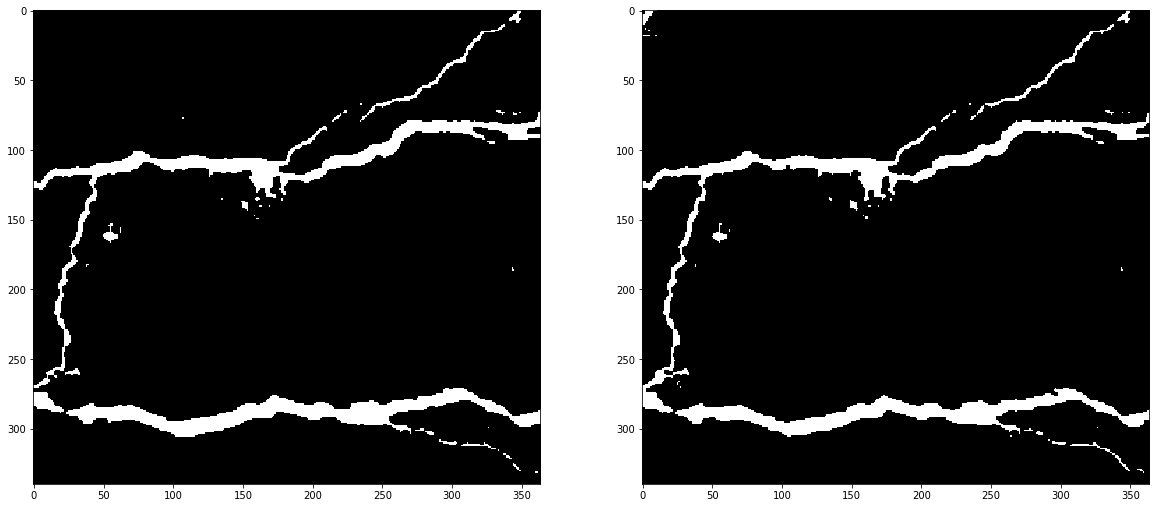

In [10]:
closed_equ = closing(binary_sauvola_equ, kernel)
closed = closing(binary_sauvola, kernel)

plot_print(closed,closed_equ)

# Labeling (to denoise )

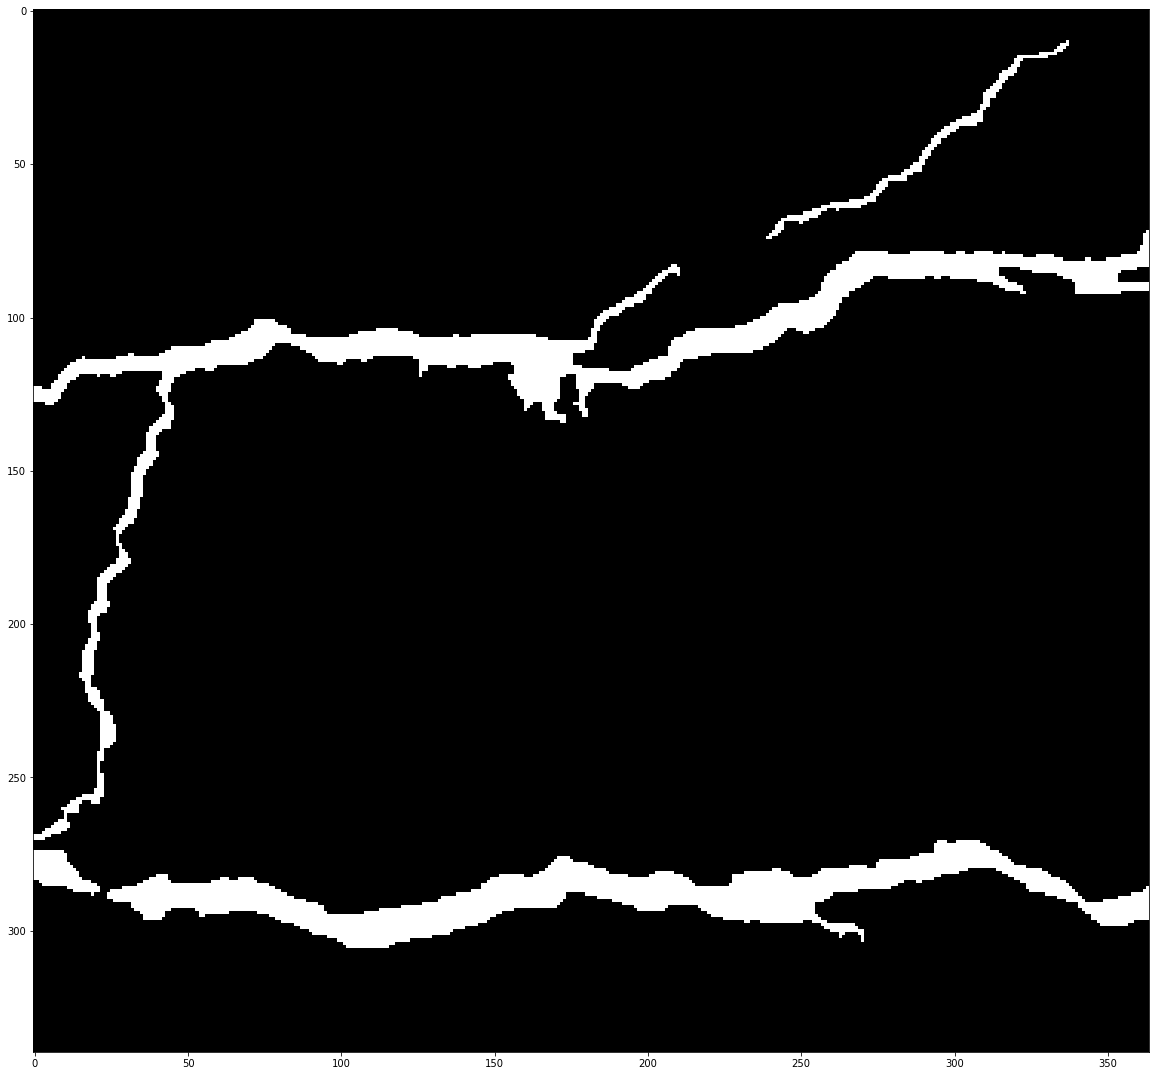

In [11]:
denoised = denoising(closed,1,20)[1]
#denoised[118:140,150:174]=0
plt.figure(figsize=(20,20))
plt.imshow(denoised)

In [12]:
denoising(closed,1,20)[0]

,area
label,
29,535
2,822
28,4331
6,8344


# Skeletonize

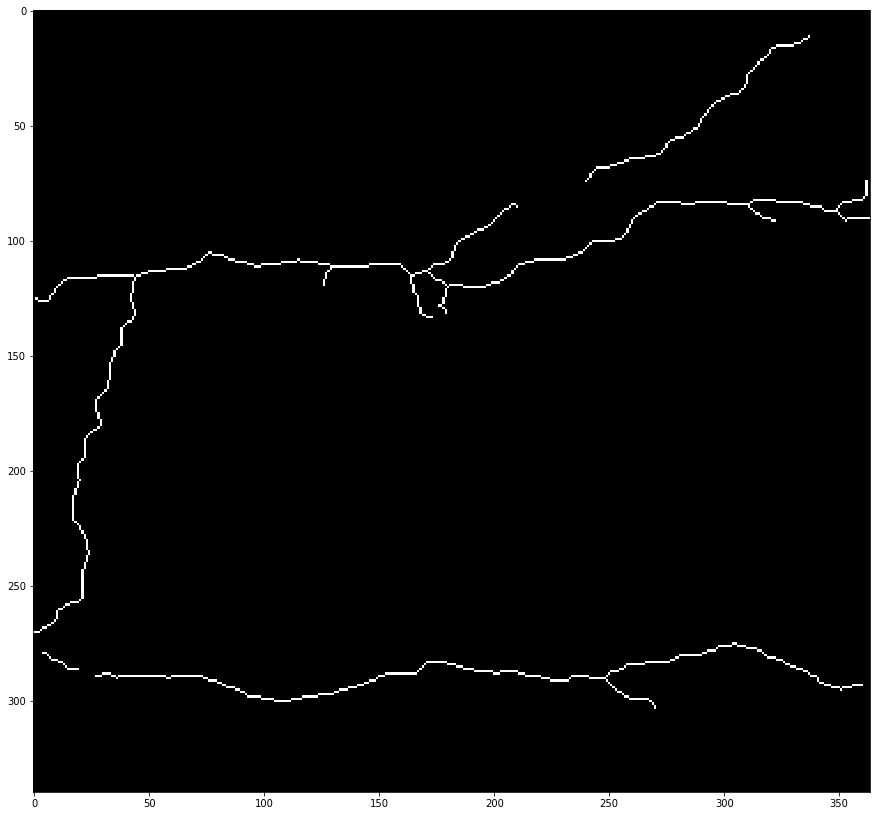

In [13]:
from skimage.morphology import skeletonize

skeleton = skeletonize(denoised,method='lee')

plt.figure(figsize=(15,15))
plt.imshow(skeleton)

# Crack Sepration 

In [14]:
seprated, branch_points, windows, edge_dots, seprating_mask = edgedot(denoised,skeleton,7)

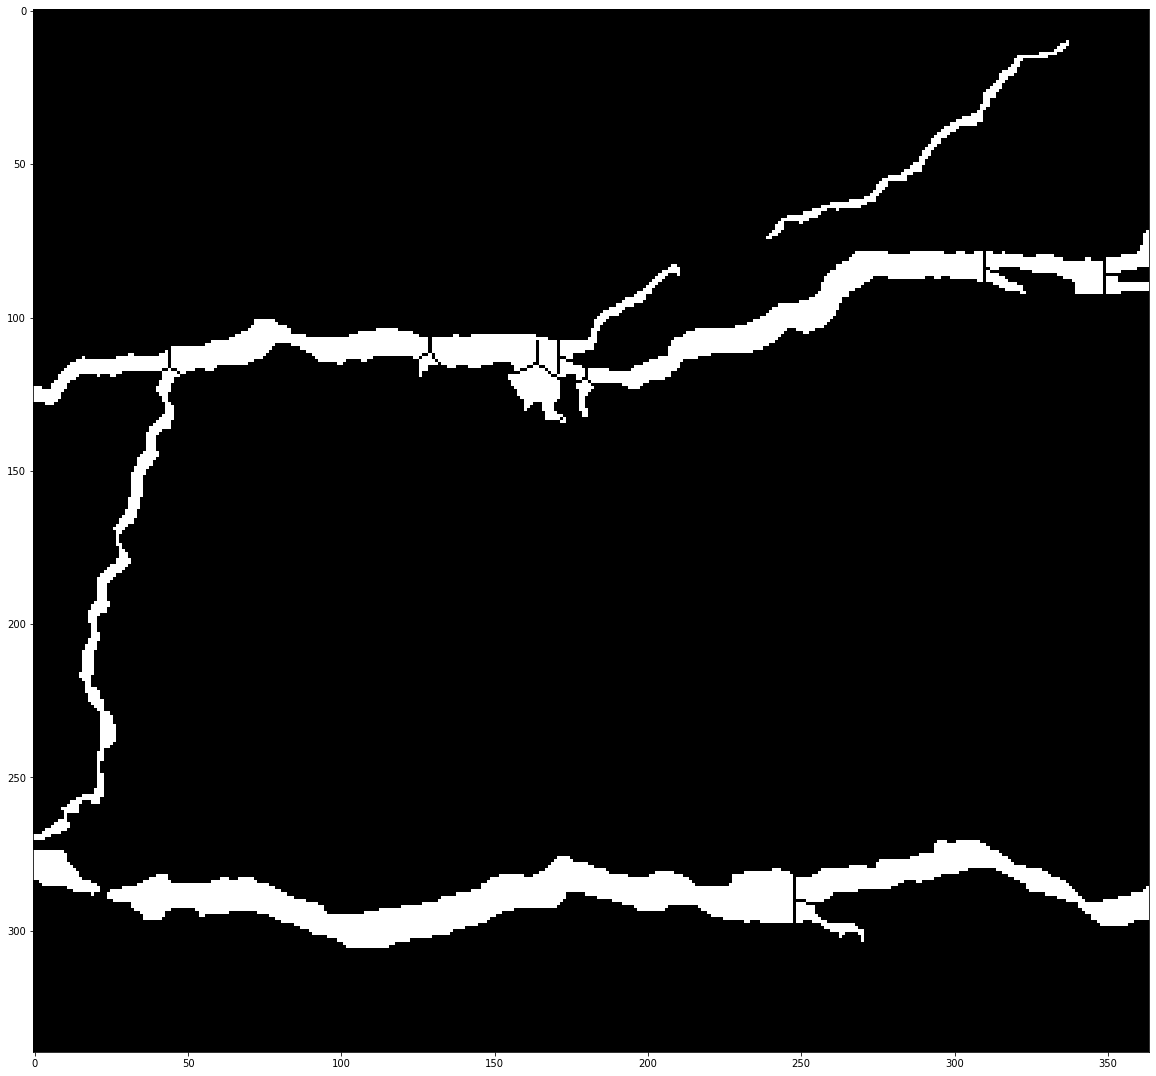

In [15]:
plt.figure(figsize=(20,20))
plt.imshow(seprated)

In [16]:
branch_points

[(84, 310),
 (86, 349),
 (111, 129),
 (113, 171),
 (115, 164),
 (116, 44),
 (120, 180),
 (128, 177),
 (290, 248)]

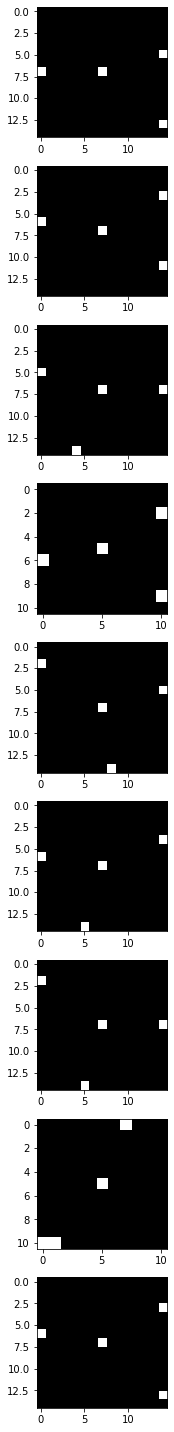

In [17]:
plt.figure(figsize=(20,20))

for n, single_w in enumerate(windows):
    ax = plt.subplot(len(windows), 1, n+1)

    plt.imshow(single_w)
plt.tight_layout()
plt.show()

In [18]:
edge_dots

{0: [(7, 7), (5, 14), (7, 0), (13, 14)],
 1: [(7, 7), (3, 14), (6, 0), (11, 14)],
 2: [(7, 7), (5, 0), (7, 14), (14, 4)],
 3: [(5, 5), (2, 10), (6, 0), (9, 10)],
 4: [(7, 7), (2, 0), (5, 14), (14, 8)],
 5: [(7, 7), (4, 14), (6, 0), (14, 5)],
 6: [(7, 7), (2, 0), (7, 14), (14, 5)],
 7: [(5, 5), (10, 0), (10, 1), (0, 7)],
 8: [(7, 7), (3, 14), (6, 0), (13, 14)]}

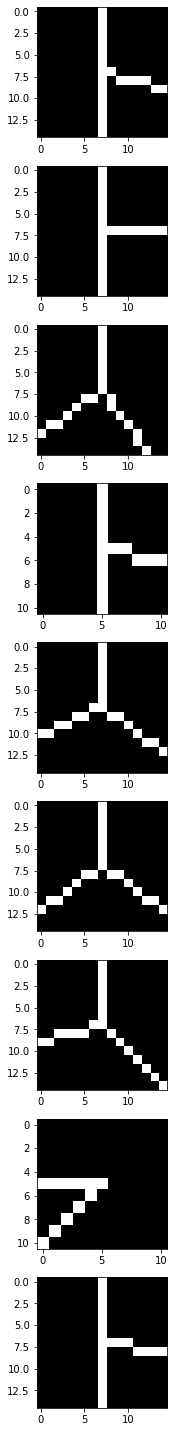

In [19]:
plt.figure(figsize=(20,20))

for n, single_w in enumerate(seprating_mask):
    ax = plt.subplot(len(seprating_mask), 1, n+1)

    plt.imshow(single_w)
plt.tight_layout()
plt.show()

# Crack labeling 

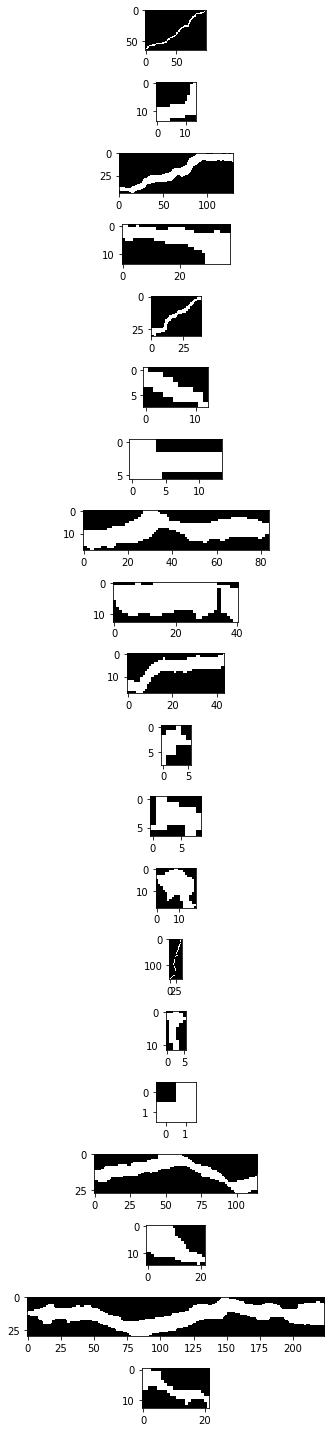

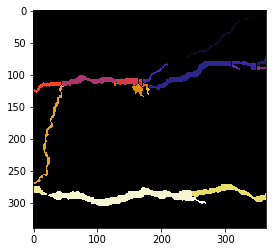

In [20]:
crack_labeling(seprated)

# Remove Non-crack Objects and Crack quantification

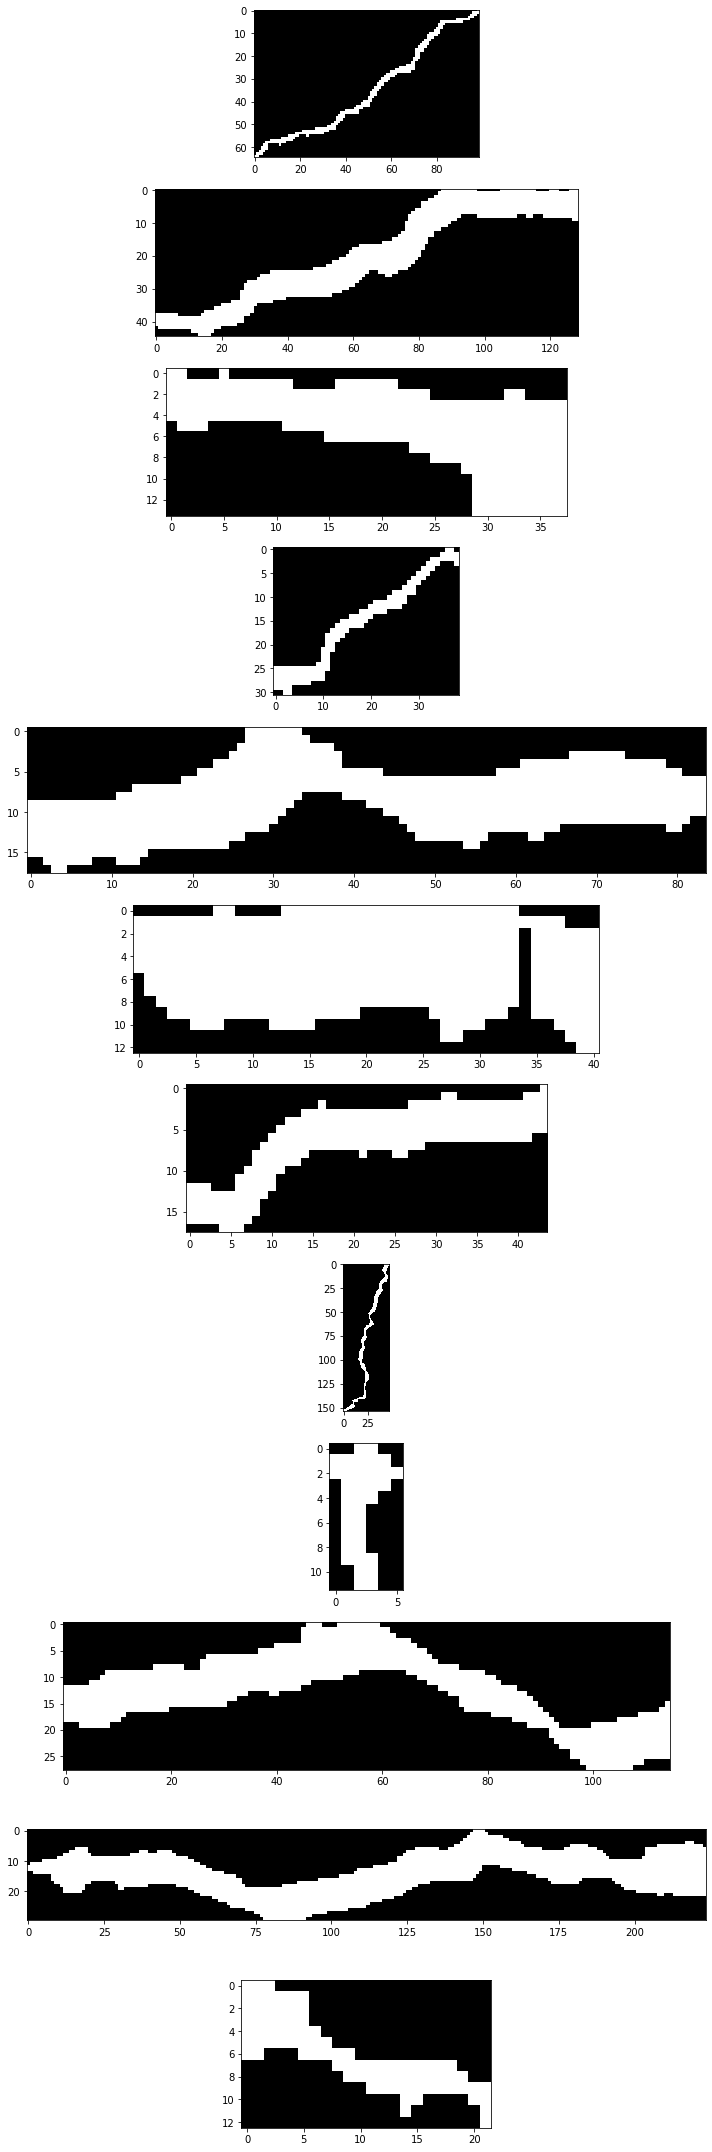

,cracks_slice,cracks_width_mean,cracks_angle_mean
0,"(1, (slice(10, 75, None), slice(239, 338, None)))",2.733945,30.656934
1,"(3, (slice(79, 124, None), slice(181, 310, Non...",8.904688,6.744186
2,"(4, (slice(79, 93, None), slice(311, 349, None)))",6.272727,2.727273
3,"(5, (slice(83, 114, None), slice(172, 211, Non...",3.428571,23.265306
4,"(8, (slice(101, 119, None), slice(45, 129, Non...",8.234568,0.000000
5,"(9, (slice(106, 119, None), slice(130, 171, No...",9.664706,0.000000
6,"(10, (slice(111, 129, None), slice(0, 44, None)))",5.472727,6.666667
7,"(14, (slice(117, 271, None), slice(0, 48, None)))",3.625926,78.461538
8,"(15, (slice(121, 133, None), slice(177, 183, N...",2.575000,90.000000
9,"(17, (slice(271, 299, None), slice(249, 364, N...",7.971171,0.000000


In [21]:
crack_quantification(seprated,f=.1)[0]